In [2]:
# load custom packages from src dir
import sys
sys.path.insert(0, '..')

# python packages
import logging
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from tqdm import tqdm

# vit package - https://github.com/lucidrains/vit-pytorch
import vit_pytorch as vit

# custom packages
import src.commons.dataset as ds
import src.commons.constants as cons
from src.commons.modded_recorder import Recorder

# Define the logging level
logging.getLogger().setLevel(logging.INFO)

# <span style="color:green">Vision Transformer so far</span>

We have tested ViT training with weak supervision in the notebook `nb_2_vision_transformer_tests.ipynb`. We also implemented a routine to pre-train ViTs in the TinyImagenet dataset (`nb_3_ViT_pretraining.ipynb`). Finally, we implemented a custom dataset in `src/commons/dataset.py` to tackle this weak supervision training.

Now, the goal is to:
1. Load data using the custom dataset
2. Load pretrained models
3. Fine tune them in the MVTec data
4. Inspect results
   1. Accuracy of "is anomaly" binary prediction
   2. Visualize segmentation masks extracted from attention
5. Use different patch sizes to obtain masks at different resolutions, and combine the results
6. Compare the ensemble results with the previous results


## Initialize data

Desired image transformations should be included in the `transforms.Compose` wrapper.

*Note:* what sort of data augmentation may be useful for our task?

*Note 2:* should we implement transforms only at the dataloader level?

In [3]:
# Load dataset
cat = "hazelnut"
transf = transforms.Compose([
    transforms.Resize((64, 64)), # Resize to match TinyImagenet resolution
    transforms.Lambda(lambda T: T.long()/255) # Convert image from 0-255 uint to 0-1 long
])
data = ds.MVTECViTDataset(os.path.join(ds.current_dir(),'../', cons.DATA_PATH), cat, transforms=transf)

# Split data into train/test/val
train_data, test_data, val_data = torch.utils.data.random_split(data, [0.7, 0.2, 0.1])

In [4]:
# Define DataLoaders for batching input
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
def show_img_and_mask(img, mask, ex_name):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
    ax1.imshow(torch.permute(img, (1, 2, 0)))
    ax1.set_title('Raw image')
    ax2.imshow(torch.permute(img, (1, 2, 0)))
    ax2.imshow(torch.permute(mask, (1, 2, 0)), cmap="spring", alpha=0.5, vmax=mask.max()/2)
    ax2.set_title('Ground truth mask')
    fig.suptitle(ex_name)
    plt.show()

In [6]:
for sample in data:
    if ('011' in sample['class_and_id']) and ('crack' in sample['class_and_id']):
        img1, mask1, ex_name1 = sample["inputs"], sample["ground_truth"], sample['class_and_id']
    elif ('010' in sample['class_and_id']) and ('hole' in sample['class_and_id']):
        img2, mask2, ex_name2 = sample["inputs"], sample["ground_truth"], sample['class_and_id']

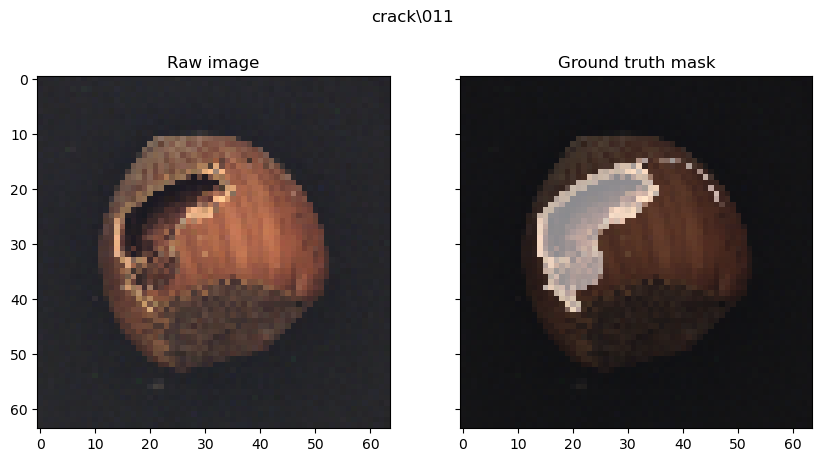

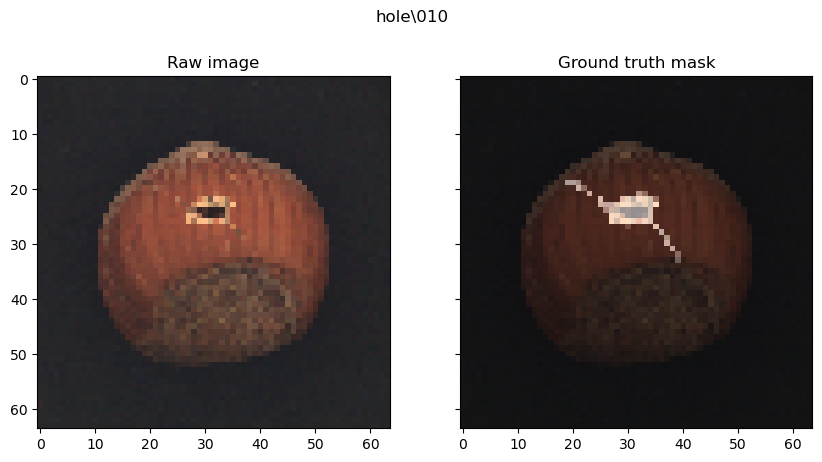

In [8]:
show_img_and_mask(img1, mask1, ex_name1)
show_img_and_mask(img2, mask2, ex_name2)

## Load pre-trained model

*Note: * what is the best way to handle hyper-parameter definition / storage?

In [122]:
# Pretrained model hyper-parameters
CHECKPOINT_PATH = ".." + cons.DIR_SEP + os.path.join("results")
PATCH_SIZE = 4
HIDDEN_DIM = 256

# Load pretrained model
model = vit.SimpleViT(
    image_size = 64,
    patch_size = PATCH_SIZE,
    num_classes = 200,
    dim = HIDDEN_DIM,
    depth = 2,
    heads = 8,
    mlp_dim = 512
).to("cpu")

loaded = torch.load(os.path.join(CHECKPOINT_PATH, "simple_vit_pretrained_0.pt"))
print(f"Loaded model, epoch:{loaded['epoch']}, loss:{loaded['loss']}")
model.load_state_dict(loaded["model_state_dict"])

for p in model.parameters():
     p.requires_grad = False

model.linear_head[-1] = nn.Sequential(
    nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
    nn.ReLU(),
    nn.Linear(HIDDEN_DIM, 1)
)

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_frozen_parameters(model):
    return sum(p.numel() for p in model.parameters() if not p.requires_grad)

print(f"Trainable params: {count_trainable_parameters(model)}")
print(f"Frozen params: {count_frozen_parameters(model)}")

model

Loaded model, epoch:16, loss:3.3293343412990386
Trainable params: 66049
Frozen params: 1589504


SimpleViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1=4, p2=4)
    (1): Linear(in_features=48, out_features=256, bias=True)
  )
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (to_qkv): Linear(in_features=256, out_features=1536, bias=False)
          (to_out): Linear(in_features=512, out_features=256, bias=False)
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=256, out_features=512, bias=True)
            (2): GELU(approximate='none')
            (3): Linear(in_features=512, out_features=256, bias=True)
          )
        )
      )
      (1): ModuleList(
        (0): Attention(
          (norm): LayerNorm((256,), eps=1e-05, elementwise_aff

## Fine tuning routine

In [123]:
def evaluate(model, data_loader, **kwargs):
    loss_fn = kwargs.get("loss_fn", nn.BCEWithLogitsLoss())
    device = kwargs.get("device", torch.device("cpu"))
    
    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    avg_loss, avg_acc = 0., 0.
    for i, batch in pbar:

        inputs, targets = batch["inputs"], batch["labels"]
        inputs, targets = inputs.to(device), targets.to(device)
        
        model.zero_grad() # initialize gradients to zero
        with torch.no_grad(): # no need to compute gradients
            logits = model(inputs)
            preds = torch.sigmoid(logits)
            pred_cats = preds > 0.5
            acc = (pred_cats == targets).float().mean()
           
        loss = loss_fn(logits, targets.float())
        avg_loss += loss.item()
        avg_acc += acc.item()
        pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")
    avg_loss /= len(data_loader)
    avg_acc /= len(data_loader)
    return avg_loss, avg_acc

def fit(model, train_loader, val_loader, optimizer, **kwargs):
    loss_fn = kwargs.get("loss_fn", nn.BCEWithLogitsLoss())
    device = kwargs.get("device", torch.device("cpu"))
    num_epochs = kwargs.get("num_epochs", 100)

    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []

    for epoch in range(num_epochs):
        # Checkpoint if validation loss improves  
        if epoch > 2 and val_loss_hist[-2] > val_loss_hist[-1]:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': val_loss_hist[-1],
                    }, os.path.join(CHECKPOINT_PATH, "simple_vit_ft.pt"))

        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        model.train() # set model to training mode
        train_loss, train_acc = 0., 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, batch in pbar:
            
            inputs, targets = batch["inputs"], batch["labels"]
            inputs, targets = inputs.to(device), targets.to(device)
    
            # print(f"Batch - Input: {inputs.shape, type(inputs), inputs.dtype} Target: {targets.shape, type(targets), targets.dtype}")

            model.zero_grad() # initialize gradients to zero
            logits = model(inputs) # forward pass

            # print(f"Logits - {logits.shape}, {type(logits)}, {logits.dtype}")

            loss = loss_fn(logits, targets.float()) # loss computation
            loss.backward() # computing gradients (backward pass)
            
            optimizer.step() # updating the parameters of the model
            # accuracy computation
            with torch.no_grad():
                preds = torch.sigmoid(logits)
                pred_cats = preds > 0.5
                acc = (pred_cats == targets).float().mean()
    
            # pop computational graph
            train_loss += loss.item()
            train_acc += acc.item() 
            pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")
        

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        print(f"Train loss: {train_loss:.3f} | train acc = {train_acc:.3f}")
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc) 
        
        val_loss, val_acc = evaluate(model, val_loader, loss_fn=loss_fn, device=device)
        print(f"Validation loss: {val_loss:.3f} | val acc = {val_acc:.3f}")
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)
        
    return train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist

In [124]:
# Define training parameters
LEARNING_RATE = 5e-5
NUM_EPOCHS = 20
print("BATCH SIZE: ", BATCH_SIZE)
print("CHECKPOINT PATH: ", CHECKPOINT_PATH)
print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad) :.2e}")

# Define loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.BCEWithLogitsLoss()

# Attempt training on GPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print('DEVICE:', DEVICE)

# Send to device
model = model.to(DEVICE)
print(torch.cuda.memory_summary())

BATCH SIZE:  32
CHECKPOINT PATH:  ..\results
Total parameters: 6.60e+04
DEVICE: cuda
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   94478 KB |  636693 KB |    2292 GB |    2292 GB |
|       from large pool |   46080 KB |  584704 KB |    2273 GB |    2273 GB |
|       from small pool |   48398 KB |   62153 KB |      18 GB |      18 GB |
|---------------------------------------------------------------------------|
| Active memory         |   94478 KB |  636693 KB |    22

In [125]:
# Training
train_loss, val_loss, train_acc, val_acc = fit(model, train_dataloader, val_dataloader, optimizer,
                                               loss_fn=criterion, num_epochs=NUM_EPOCHS, device=DEVICE)


Epoch 1/20


loss = 0.623 | acc = 0.935: 100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


Train loss: 0.719 | train acc = 0.412


loss = 0.606 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


Validation loss: 0.611 | val acc = 0.882

Epoch 2/20


loss = 0.564 | acc = 0.742: 100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


Train loss: 0.552 | train acc = 0.869


loss = 0.496 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Validation loss: 0.478 | val acc = 0.870

Epoch 3/20


loss = 0.331 | acc = 0.968: 100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


Train loss: 0.452 | train acc = 0.864


loss = 0.308 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


Validation loss: 0.382 | val acc = 0.894

Epoch 4/20


loss = 0.334 | acc = 0.903: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.405 | train acc = 0.855


loss = 0.448 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Validation loss: 0.385 | val acc = 0.870

Epoch 5/20


loss = 0.368 | acc = 0.871: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.385 | train acc = 0.855


loss = 0.521 | acc = 0.778: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Validation loss: 0.387 | val acc = 0.858

Epoch 6/20


loss = 0.279 | acc = 0.903: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


Train loss: 0.373 | train acc = 0.855


loss = 0.259 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Validation loss: 0.323 | val acc = 0.894

Epoch 7/20


loss = 0.263 | acc = 0.935: 100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


Train loss: 0.366 | train acc = 0.861


loss = 0.139 | acc = 1.000: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


Validation loss: 0.293 | val acc = 0.906

Epoch 8/20


loss = 0.554 | acc = 0.774: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


Train loss: 0.361 | train acc = 0.860


loss = 0.267 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Validation loss: 0.318 | val acc = 0.882

Epoch 9/20


loss = 0.304 | acc = 0.903: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.355 | train acc = 0.866


loss = 0.441 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


Validation loss: 0.354 | val acc = 0.870

Epoch 10/20


loss = 0.411 | acc = 0.806: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.350 | train acc = 0.866


loss = 0.584 | acc = 0.722: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Validation loss: 0.383 | val acc = 0.845

Epoch 11/20


loss = 0.340 | acc = 0.903: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.345 | train acc = 0.866


loss = 0.280 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Validation loss: 0.314 | val acc = 0.882

Epoch 12/20


loss = 0.310 | acc = 0.903: 100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


Train loss: 0.341 | train acc = 0.875


loss = 0.328 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


Validation loss: 0.322 | val acc = 0.882

Epoch 13/20


loss = 0.249 | acc = 0.935: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


Train loss: 0.336 | train acc = 0.878


loss = 0.345 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


Validation loss: 0.324 | val acc = 0.870

Epoch 14/20


loss = 0.432 | acc = 0.774: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.332 | train acc = 0.877


loss = 0.426 | acc = 0.778: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Validation loss: 0.339 | val acc = 0.858

Epoch 15/20


loss = 0.185 | acc = 0.935: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.327 | train acc = 0.878


loss = 0.301 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Validation loss: 0.310 | val acc = 0.882

Epoch 16/20


loss = 0.304 | acc = 0.903: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


Train loss: 0.323 | train acc = 0.880


loss = 0.133 | acc = 1.000: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Validation loss: 0.270 | val acc = 0.906

Epoch 17/20


loss = 0.310 | acc = 0.871: 100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


Train loss: 0.319 | train acc = 0.880


loss = 0.303 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


Validation loss: 0.305 | val acc = 0.882

Epoch 18/20


loss = 0.426 | acc = 0.839: 100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


Train loss: 0.316 | train acc = 0.880


loss = 0.157 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


Validation loss: 0.271 | val acc = 0.894

Epoch 19/20


loss = 0.239 | acc = 0.968: 100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


Train loss: 0.311 | train acc = 0.892


loss = 0.302 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Validation loss: 0.301 | val acc = 0.870

Epoch 20/20


loss = 0.284 | acc = 0.903: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.308 | train acc = 0.892


loss = 0.185 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

Validation loss: 0.274 | val acc = 0.910


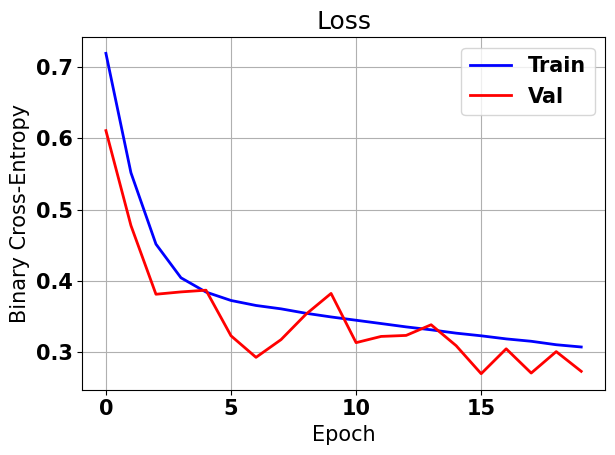

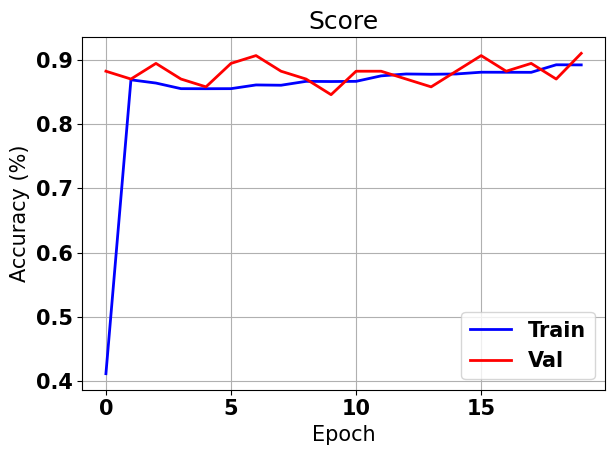

In [126]:
# Plot loss and accuracy
with plt.rc_context(rc={'font.size': 15, 'font.weight': 'bold'}):
    plt.figure()
    plt.title("Loss")
    plt.plot(train_loss, lw=2.0, c="b", label="Train")
    plt.plot(val_loss, lw=2.0, c="r", label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-Entropy")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    ####
    plt.figure()
    plt.title("Score")
    plt.plot(train_acc, lw=2.0, c="b", label="Train")
    plt.plot(val_acc, lw=2.0, c="r", label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [127]:
LEARNING_RATE = 1e-5
NUM_EPOCHS = 80

for p in model.parameters():
    p.requires_grad = True


print(f"Trainable params: {count_trainable_parameters(model)}")
print(f"Frozen params: {count_frozen_parameters(model)}")

Trainable params: 1655553
Frozen params: 0


In [128]:
# Training the complete model
temp1, temp2, temp3, temp4 = fit(model, train_dataloader, val_dataloader, optimizer,
                                 loss_fn=criterion, num_epochs=NUM_EPOCHS, device=DEVICE)

train_loss += temp1
val_loss += temp2
train_acc += temp3
val_acc += temp4



Epoch 1/80


loss = 0.384 | acc = 0.871: 100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


Train loss: 0.390 | train acc = 0.860


loss = 0.357 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


Validation loss: 0.344 | val acc = 0.882

Epoch 2/80


loss = 0.290 | acc = 0.903: 100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


Train loss: 0.342 | train acc = 0.880


loss = 0.350 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Validation loss: 0.330 | val acc = 0.898

Epoch 3/80


loss = 0.322 | acc = 0.903: 100%|██████████| 11/11 [00:10<00:00,  1.10it/s]


Train loss: 0.292 | train acc = 0.889


loss = 0.307 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Validation loss: 0.317 | val acc = 0.882

Epoch 4/80


loss = 0.264 | acc = 0.903: 100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


Train loss: 0.239 | train acc = 0.923


loss = 0.274 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


Validation loss: 0.262 | val acc = 0.898

Epoch 5/80


loss = 0.303 | acc = 0.871: 100%|██████████| 11/11 [00:10<00:00,  1.04it/s]


Train loss: 0.205 | train acc = 0.917


loss = 0.163 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


Validation loss: 0.235 | val acc = 0.910

Epoch 6/80


loss = 0.253 | acc = 0.935: 100%|██████████| 11/11 [00:10<00:00,  1.04it/s]


Train loss: 0.164 | train acc = 0.946


loss = 0.690 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Validation loss: 0.427 | val acc = 0.885

Epoch 7/80


loss = 0.297 | acc = 0.871: 100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


Train loss: 0.179 | train acc = 0.929


loss = 0.091 | acc = 1.000: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Validation loss: 0.198 | val acc = 0.938

Epoch 8/80


loss = 0.083 | acc = 0.968: 100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


Train loss: 0.126 | train acc = 0.960


loss = 0.747 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Validation loss: 0.457 | val acc = 0.901

Epoch 9/80


loss = 0.090 | acc = 0.968: 100%|██████████| 11/11 [00:10<00:00,  1.10it/s]


Train loss: 0.119 | train acc = 0.963


loss = 0.195 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Validation loss: 0.309 | val acc = 0.925

Epoch 10/80


loss = 0.120 | acc = 0.968: 100%|██████████| 11/11 [00:09<00:00,  1.10it/s]


Train loss: 0.122 | train acc = 0.963


loss = 0.679 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Validation loss: 0.418 | val acc = 0.901

Epoch 11/80


loss = 0.040 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.131 | train acc = 0.963


loss = 0.297 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Validation loss: 0.275 | val acc = 0.898

Epoch 12/80


loss = 0.101 | acc = 0.935: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.077 | train acc = 0.971


loss = 0.354 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Validation loss: 0.322 | val acc = 0.913

Epoch 13/80


loss = 0.010 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.044 | train acc = 0.991


loss = 0.534 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


Validation loss: 0.424 | val acc = 0.913

Epoch 14/80


loss = 0.085 | acc = 0.968: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


Train loss: 0.073 | train acc = 0.974


loss = 0.340 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


Validation loss: 0.341 | val acc = 0.866

Epoch 15/80


loss = 0.088 | acc = 0.968: 100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


Train loss: 0.085 | train acc = 0.971


loss = 0.021 | acc = 1.000: 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


Validation loss: 0.288 | val acc = 0.938

Epoch 16/80


loss = 0.152 | acc = 0.935: 100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


Train loss: 0.125 | train acc = 0.949


loss = 0.526 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


Validation loss: 0.410 | val acc = 0.913

Epoch 17/80


loss = 0.068 | acc = 0.968: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Train loss: 0.045 | train acc = 0.989


loss = 0.614 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


Validation loss: 0.432 | val acc = 0.870

Epoch 18/80


loss = 0.010 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


Train loss: 0.025 | train acc = 0.994


loss = 0.407 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Validation loss: 0.376 | val acc = 0.870

Epoch 19/80


loss = 0.011 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


Train loss: 0.020 | train acc = 0.997


loss = 0.715 | acc = 0.778: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Validation loss: 0.454 | val acc = 0.873

Epoch 20/80


loss = 0.015 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Train loss: 0.014 | train acc = 1.000


loss = 0.703 | acc = 0.778: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Validation loss: 0.460 | val acc = 0.858

Epoch 21/80


loss = 0.009 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


Train loss: 0.011 | train acc = 1.000


loss = 0.347 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Validation loss: 0.423 | val acc = 0.898

Epoch 22/80


loss = 0.005 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.008 | train acc = 1.000


loss = 0.773 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


Validation loss: 0.523 | val acc = 0.870

Epoch 23/80


loss = 0.005 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.007 | train acc = 1.000


loss = 0.070 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


Validation loss: 0.372 | val acc = 0.894

Epoch 24/80


loss = 0.002 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.006 | train acc = 1.000


loss = 0.359 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Validation loss: 0.445 | val acc = 0.925

Epoch 25/80


loss = 0.008 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Train loss: 0.005 | train acc = 1.000


loss = 0.716 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Validation loss: 0.529 | val acc = 0.870

Epoch 26/80


loss = 0.003 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.004 | train acc = 1.000


loss = 0.383 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Validation loss: 0.461 | val acc = 0.910

Epoch 27/80


loss = 0.004 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


Train loss: 0.004 | train acc = 1.000


loss = 0.361 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Validation loss: 0.461 | val acc = 0.894

Epoch 28/80


loss = 0.002 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Train loss: 0.003 | train acc = 1.000


loss = 0.601 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Validation loss: 0.521 | val acc = 0.885

Epoch 29/80


loss = 0.002 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


Train loss: 0.003 | train acc = 1.000


loss = 0.372 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Validation loss: 0.475 | val acc = 0.894

Epoch 30/80


loss = 0.002 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Train loss: 0.003 | train acc = 1.000


loss = 0.609 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Validation loss: 0.529 | val acc = 0.885

Epoch 31/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Train loss: 0.003 | train acc = 1.000


loss = 0.451 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Validation loss: 0.497 | val acc = 0.870

Epoch 32/80


loss = 0.002 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


Train loss: 0.002 | train acc = 1.000


loss = 0.410 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Validation loss: 0.491 | val acc = 0.910

Epoch 33/80


loss = 0.003 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.002 | train acc = 1.000


loss = 0.792 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Validation loss: 0.579 | val acc = 0.870

Epoch 34/80


loss = 0.002 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Train loss: 0.002 | train acc = 1.000


loss = 0.252 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


Validation loss: 0.465 | val acc = 0.910

Epoch 35/80


loss = 0.002 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.002 | train acc = 1.000


loss = 0.402 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Validation loss: 0.503 | val acc = 0.910

Epoch 36/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


Train loss: 0.002 | train acc = 1.000


loss = 0.237 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Validation loss: 0.470 | val acc = 0.894

Epoch 37/80


loss = 0.002 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Train loss: 0.002 | train acc = 1.000


loss = 0.030 | acc = 1.000: 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


Validation loss: 0.428 | val acc = 0.922

Epoch 38/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


Train loss: 0.002 | train acc = 1.000


loss = 0.580 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Validation loss: 0.553 | val acc = 0.882

Epoch 39/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Train loss: 0.001 | train acc = 1.000


loss = 0.287 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Validation loss: 0.492 | val acc = 0.910

Epoch 40/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


Train loss: 0.001 | train acc = 1.000


loss = 0.265 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Validation loss: 0.489 | val acc = 0.910

Epoch 41/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.001 | train acc = 1.000


loss = 1.009 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Validation loss: 0.655 | val acc = 0.885

Epoch 42/80


loss = 0.002 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Train loss: 0.001 | train acc = 1.000


loss = 1.105 | acc = 0.778: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


Validation loss: 0.679 | val acc = 0.873

Epoch 43/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Train loss: 0.001 | train acc = 1.000


loss = 1.473 | acc = 0.778: 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


Validation loss: 0.763 | val acc = 0.873

Epoch 44/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Train loss: 0.001 | train acc = 1.000


loss = 0.416 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


Validation loss: 0.535 | val acc = 0.910

Epoch 45/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


Train loss: 0.001 | train acc = 1.000


loss = 0.799 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Validation loss: 0.622 | val acc = 0.898

Epoch 46/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Train loss: 0.001 | train acc = 1.000


loss = 0.095 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Validation loss: 0.471 | val acc = 0.910

Epoch 47/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Train loss: 0.001 | train acc = 1.000


loss = 0.795 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Validation loss: 0.626 | val acc = 0.898

Epoch 48/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


Train loss: 0.001 | train acc = 1.000


loss = 0.883 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Validation loss: 0.648 | val acc = 0.898

Epoch 49/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Train loss: 0.001 | train acc = 1.000


loss = 0.871 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Validation loss: 0.648 | val acc = 0.885

Epoch 50/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.001 | train acc = 1.000


loss = 0.743 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


Validation loss: 0.623 | val acc = 0.885

Epoch 51/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.001 | train acc = 1.000


loss = 0.560 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Validation loss: 0.586 | val acc = 0.898

Epoch 52/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Train loss: 0.001 | train acc = 1.000


loss = 0.463 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Validation loss: 0.566 | val acc = 0.910

Epoch 53/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


Train loss: 0.001 | train acc = 1.000


loss = 0.027 | acc = 1.000: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Validation loss: 0.474 | val acc = 0.922

Epoch 54/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.001 | train acc = 1.000


loss = 0.967 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Validation loss: 0.682 | val acc = 0.885

Epoch 55/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Train loss: 0.001 | train acc = 1.000


loss = 0.106 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Validation loss: 0.495 | val acc = 0.910

Epoch 56/80


loss = 0.000 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


Train loss: 0.001 | train acc = 1.000


loss = 0.843 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


Validation loss: 0.660 | val acc = 0.898

Epoch 57/80


loss = 0.000 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


Train loss: 0.001 | train acc = 1.000


loss = 0.750 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Validation loss: 0.642 | val acc = 0.898

Epoch 58/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


Train loss: 0.001 | train acc = 1.000


loss = 1.143 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


Validation loss: 0.730 | val acc = 0.885

Epoch 59/80


loss = 0.000 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.001 | train acc = 1.000


loss = 0.116 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


Validation loss: 0.508 | val acc = 0.910

Epoch 60/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train loss: 0.001 | train acc = 1.000


loss = 0.471 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Validation loss: 0.588 | val acc = 0.898

Epoch 61/80


loss = 0.000 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Train loss: 0.001 | train acc = 1.000


loss = 0.115 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Validation loss: 0.513 | val acc = 0.910

Epoch 62/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Train loss: 0.001 | train acc = 1.000


loss = 1.005 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Validation loss: 0.709 | val acc = 0.885

Epoch 63/80


loss = 0.000 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


Train loss: 0.001 | train acc = 1.000


loss = 1.163 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Validation loss: 0.747 | val acc = 0.885

Epoch 64/80


loss = 0.000 | acc = 1.000: 100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


Train loss: 0.000 | train acc = 1.000


loss = 0.025 | acc = 1.000: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Validation loss: 0.499 | val acc = 0.922

Epoch 65/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:10<00:00,  1.06it/s]


Train loss: 0.000 | train acc = 1.000


loss = 1.188 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Validation loss: 0.756 | val acc = 0.885

Epoch 66/80


loss = 0.000 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


Train loss: 0.000 | train acc = 1.000


loss = 1.185 | acc = 0.833: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Validation loss: 0.758 | val acc = 0.885

Epoch 67/80


loss = 0.000 | acc = 1.000: 100%|██████████| 11/11 [00:09<00:00,  1.10it/s]


Train loss: 0.000 | train acc = 1.000


loss = 0.099 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Validation loss: 0.523 | val acc = 0.910

Epoch 68/80


loss = 0.000 | acc = 1.000: 100%|██████████| 11/11 [00:11<00:00,  1.08s/it]


Train loss: 0.000 | train acc = 1.000


loss = 1.426 | acc = 0.778: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Validation loss: 0.814 | val acc = 0.873

Epoch 69/80


loss = 0.000 | acc = 1.000: 100%|██████████| 11/11 [00:15<00:00,  1.41s/it]


Train loss: 0.000 | train acc = 1.000


loss = 0.890 | acc = 0.889: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Validation loss: 0.700 | val acc = 0.898

Epoch 70/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:19<00:00,  1.73s/it]


Train loss: 0.000 | train acc = 1.000


loss = 0.875 | acc = 0.889: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


Validation loss: 0.700 | val acc = 0.898

Epoch 71/80


loss = 0.000 | acc = 1.000: 100%|██████████| 11/11 [00:18<00:00,  1.70s/it]


Train loss: 0.000 | train acc = 1.000


loss = 0.031 | acc = 1.000: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


Validation loss: 0.518 | val acc = 0.922

Epoch 72/80


loss = 0.001 | acc = 1.000: 100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


Train loss: 0.000 | train acc = 1.000


loss = 0.824 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Validation loss: 0.692 | val acc = 0.898

Epoch 73/80


loss = 0.000 | acc = 1.000: 100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Train loss: 0.000 | train acc = 1.000


loss = 0.901 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Validation loss: 0.710 | val acc = 0.898

Epoch 74/80


loss = 0.000 | acc = 1.000: 100%|██████████| 11/11 [00:12<00:00,  1.14s/it]


Train loss: 0.000 | train acc = 1.000


loss = 0.588 | acc = 0.889: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Validation loss: 0.644 | val acc = 0.898

Epoch 75/80


loss = 0.000 | acc = 1.000: 100%|██████████| 11/11 [00:12<00:00,  1.14s/it]


Train loss: 0.000 | train acc = 1.000


loss = 0.433 | acc = 0.944: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Validation loss: 0.612 | val acc = 0.910

Epoch 76/80


loss = 0.000 | acc = 1.000: 100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


Train loss: 0.000 | train acc = 1.000


loss = 0.579 | acc = 0.889: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


Validation loss: 0.647 | val acc = 0.898

Epoch 77/80


loss = 0.000 | acc = 1.000: 100%|██████████| 11/11 [00:19<00:00,  1.75s/it]


Train loss: 0.000 | train acc = 1.000


loss = 0.480 | acc = 0.944: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


Validation loss: 0.627 | val acc = 0.910

Epoch 78/80


loss = 0.000 | acc = 1.000: 100%|██████████| 11/11 [00:18<00:00,  1.72s/it]


Train loss: 0.000 | train acc = 1.000


loss = 0.380 | acc = 0.944: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


Validation loss: 0.607 | val acc = 0.910

Epoch 79/80


loss = 0.000 | acc = 1.000: 100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


Train loss: 0.000 | train acc = 1.000


loss = 0.000 | acc = 1.000: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


Validation loss: 0.525 | val acc = 0.922

Epoch 80/80


loss = 0.000 | acc = 1.000: 100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


Train loss: 0.000 | train acc = 1.000


loss = 1.393 | acc = 0.778: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]

Validation loss: 0.833 | val acc = 0.873


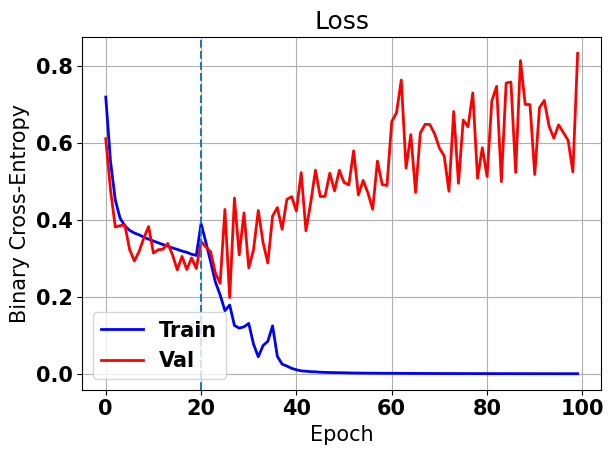

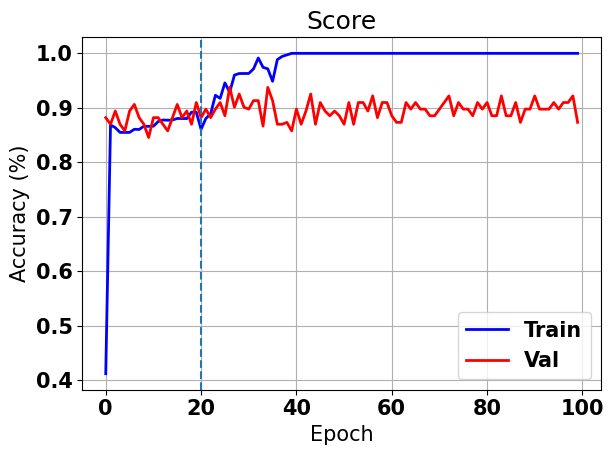

In [130]:
# Plot loss and accuracy
with plt.rc_context(rc={'font.size': 15, 'font.weight': 'bold'}):
    plt.figure()
    plt.title("Loss")
    plt.plot(train_loss, lw=2.0, c="b", label="Train")
    plt.plot(val_loss, lw=2.0, c="r", label="Val")
    plt.axvline(x=20, ls="--") # Frozen layers release
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-Entropy")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    ####
    plt.figure()
    plt.title("Score")
    plt.plot(train_acc, lw=2.0, c="b", label="Train")
    plt.plot(val_acc, lw=2.0, c="r", label="Val")
    plt.axvline(x=20, ls="--") # Frozen layers release
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [9]:
# Visualize attention layers
def predict_with_attention(model, data_loader, **kwargs):
    device = kwargs.get("device", torch.device("cpu"))

    images, labels, results, attn_weights = [], [], [], []

    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for i, batch in pbar:

        data, targets = batch["inputs"], batch["labels"]
        data, targets = data.to(device), targets.to(device)
        
        model.zero_grad() # initialize gradients to zero
        with torch.no_grad(): # no need to compute gradients
            logits, attns = model(data) # attns: (batch x layers x heads x patch x patch)
            preds = torch.sigmoid(logits)
            pred_cats = preds > 0.5

        attns = attns.mean(dim=2) # average over heads
        attns_prod = attns[:, 0] # recursively multiply attentions
        for i in range(1, attns.shape[1]):
            attns_prod = torch.matmul(attns_prod, attns[:, i])

        images.append(data)
        labels.append(targets)
        results.append(pred_cats)
        attn_weights.append(attns_prod)

    images = torch.concat(tuple([image for image in images]), dim=0)
    labels = torch.concat(tuple([label for label in labels]))
    results = torch.concat(tuple([result for result in results]))
    attn_weights = torch.concat(tuple([attn for attn in attn_weights]))

    return images, labels, results, attn_weights

In [39]:
# Pretrained model hyper-parameters
CHECKPOINT_PATH = ".." + cons.DIR_SEP + os.path.join("results")
PATCH_SIZE = 4
HIDDEN_DIM = 256

# Load pretrained model
model = vit.SimpleViT(
    image_size = 64,
    patch_size = PATCH_SIZE,
    num_classes = 200,
    dim = HIDDEN_DIM,
    depth = 2,
    heads = 8,
    mlp_dim = 512
).to("cpu")


model.linear_head[-1] = nn.Sequential(
    nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
    nn.ReLU(),
    nn.Linear(HIDDEN_DIM, 1)
)

loaded = torch.load(os.path.join(CHECKPOINT_PATH, "simple_vit_ft.pt"))
print(f"Loaded model, epoch:{loaded['epoch']}, loss:{loaded['loss']}")
model.load_state_dict(loaded["model_state_dict"])


model = Recorder(model) # set up model to return attention weights in forward pass
images, labels, pred_cats, attns = predict_with_attention(model, train_dataloader)
model = model.eject() # remove hooks from forward pass


print(images.shape, labels.shape, pred_cats.shape, attns.shape)

Loaded model, epoch:79, loss:0.524883034384402


100%|██████████| 11/11 [00:20<00:00,  1.86s/it]

torch.Size([351, 3, 64, 64]) torch.Size([351, 1]) torch.Size([351, 1]) torch.Size([351, 256, 256])


Test set: correct pred. (anomalous) 40 from total of 49


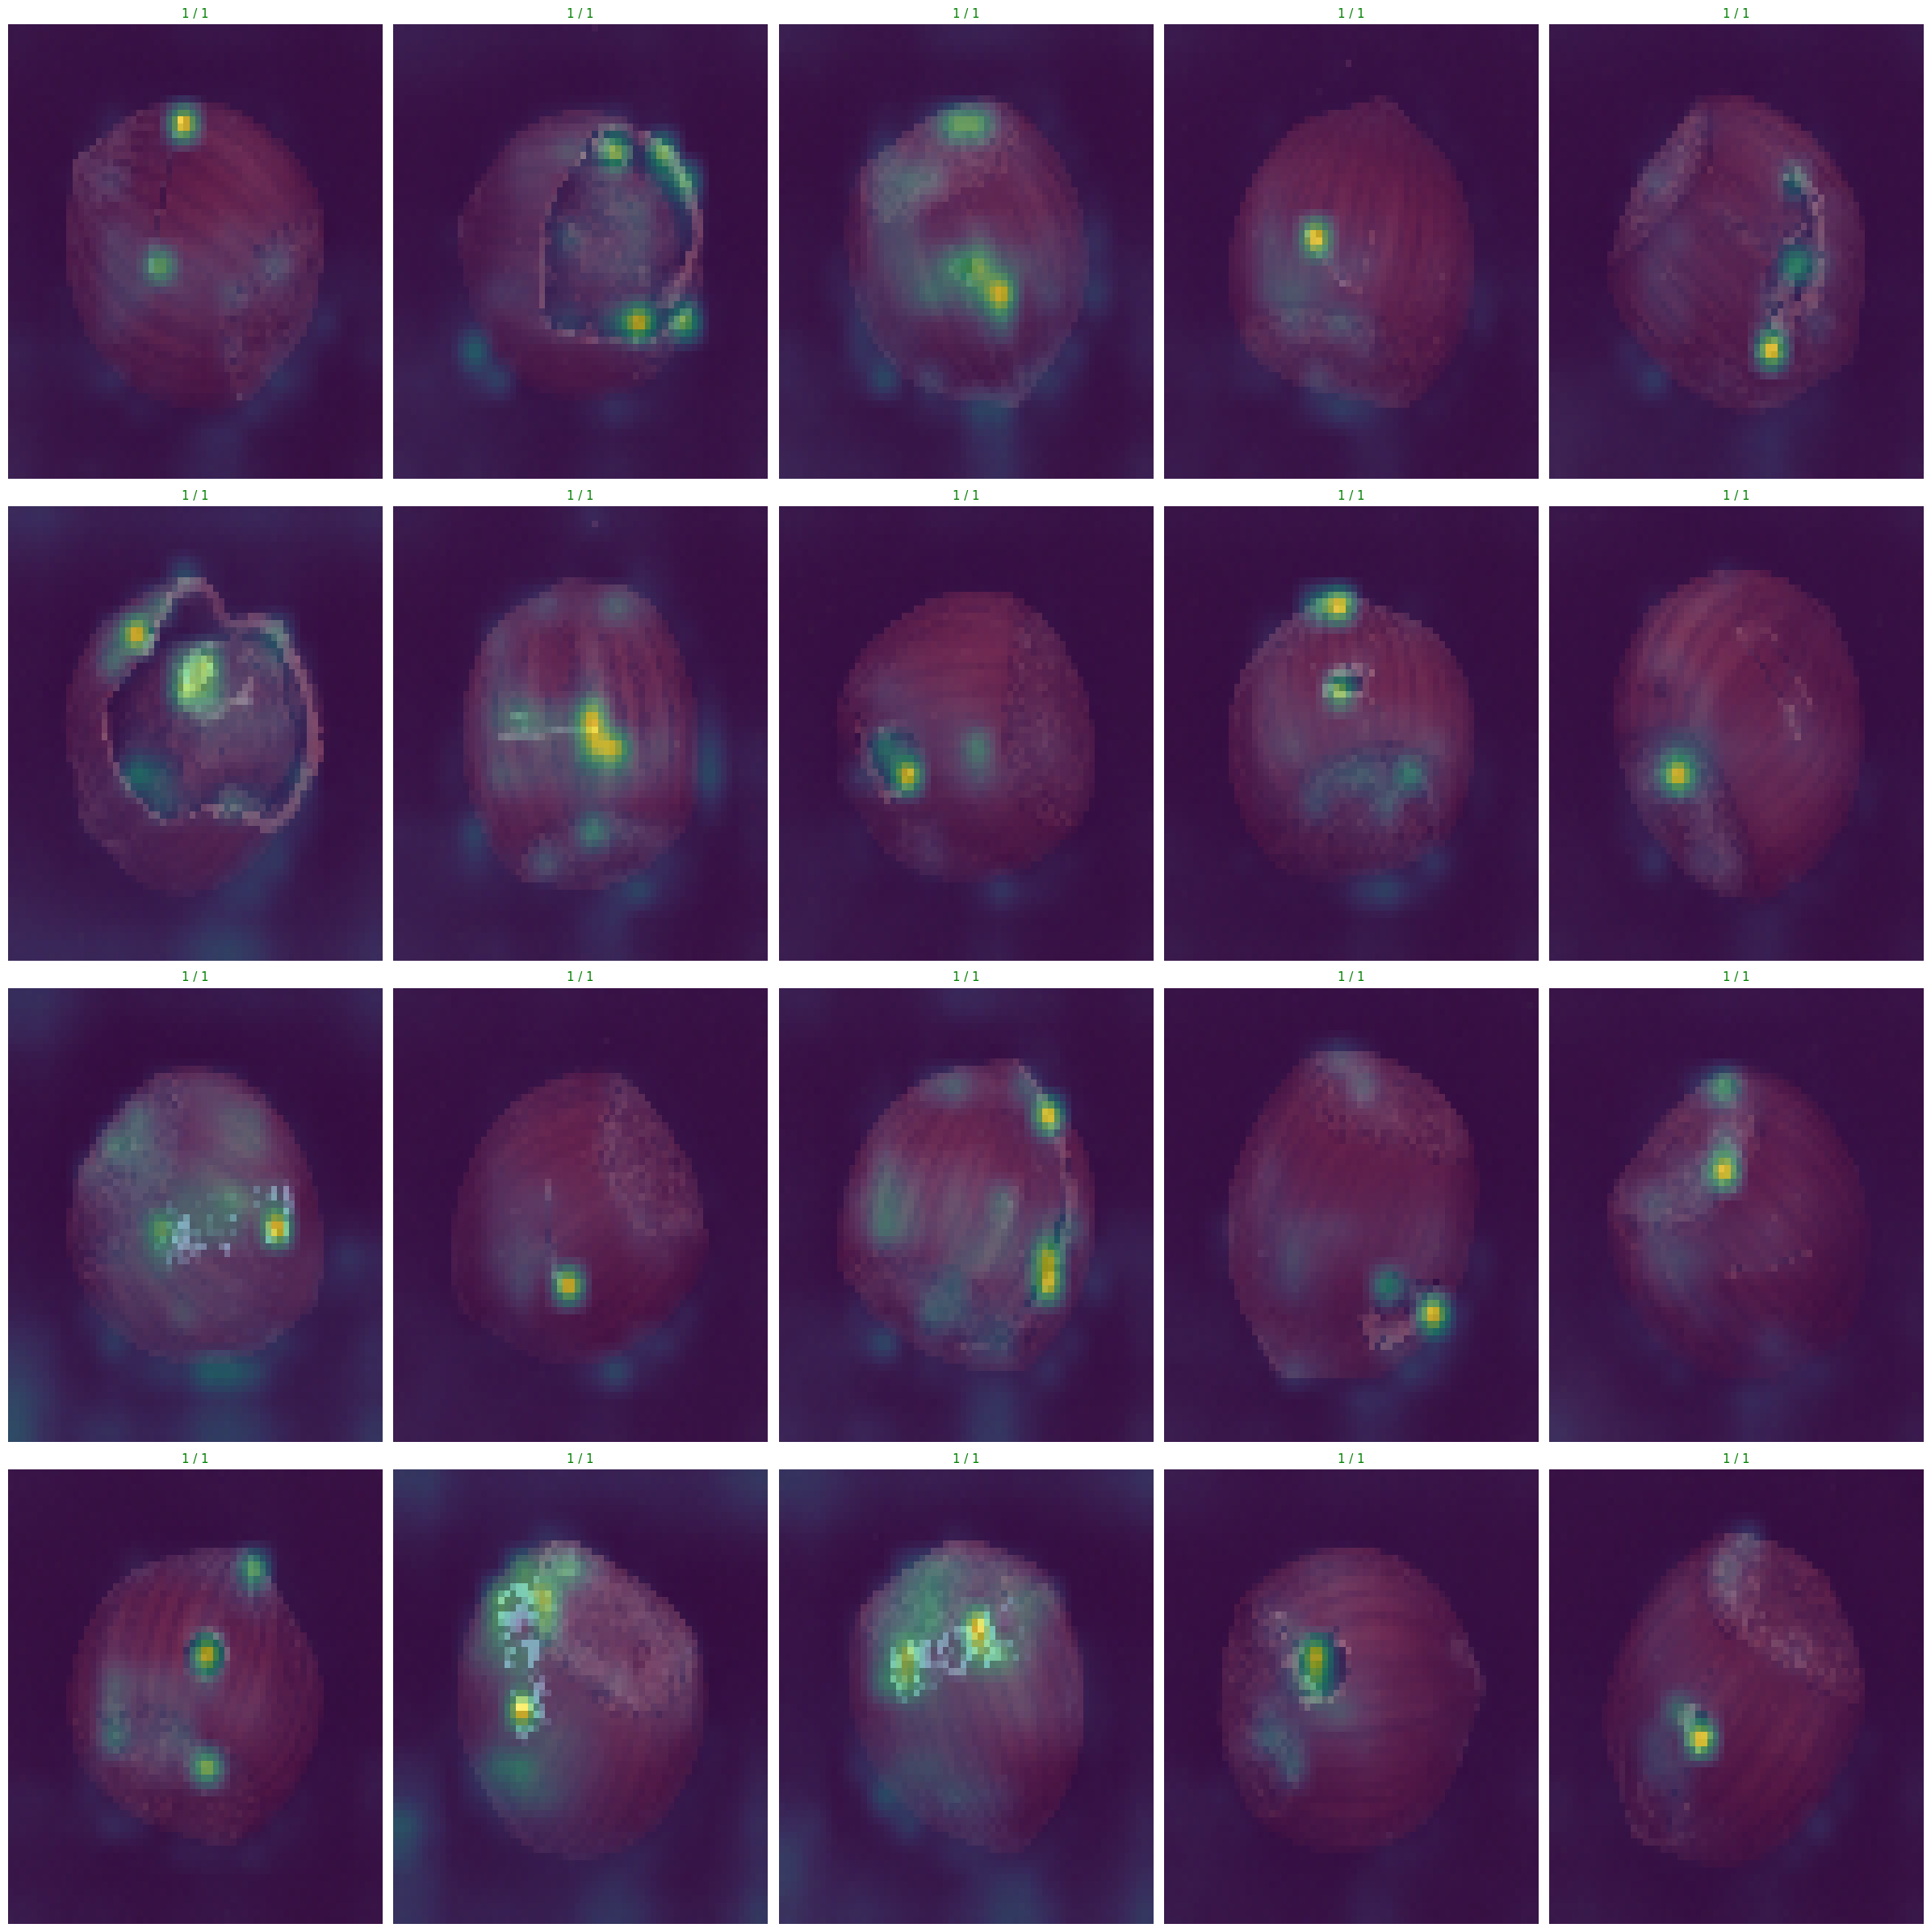

In [52]:
%matplotlib inline
# Refs: https://www.kaggle.com/code/piantic/vision-transformer-vit-visualize-attention-map/notebook

anom_idx = (labels > 0).squeeze().bool()
corrects = torch.eq(labels[anom_idx], pred_cats[anom_idx]).squeeze().bool()


print(f"Test set: correct pred. (anomalous) {corrects.sum()} from total of {anom_idx.sum()}")

idx = torch.tensor(-1, dtype=torch.int32)



fig, ax = plt.subplots(4, 5, figsize=(24, 24))
with plt.rc_context(rc={'font.size': 9}):
    for j in range(0, 4):
        for i in range(5):
            idx += 1
            # Plot correct predictions for anomalous objects
            img = images[anom_idx][corrects][idx]
            img_label = labels[anom_idx][corrects][idx]
            pred_label = pred_cats[anom_idx][corrects][idx]
            resize = transforms.Resize((64, 64))
            
            attns_raw = attns[anom_idx][corrects][idx]
            attns_vals = attns_raw[-1]
            mask = attns_vals.reshape(16, 16)
            mask = resize(mask.unsqueeze(0)).squeeze()
            mask = mask.detach().numpy()
            mask = (mask - mask.min())/(mask.max() - mask.min())

            img_perm = torch.permute(img, (1, 2, 0)).cpu().numpy()
            ax[j, i].imshow(img_perm, aspect="auto")
            ax[j, i].imshow(mask, aspect="auto", alpha=0.6, cmap="viridis")
        
            ax[j, i].set_title(f"{pred_label.int().item()} / {img_label.item()}", color="green")

            ax[j, i].set_axis_off()
    
    fig.tight_layout()